# Wavefrom {Class} Demo

In [1]:
from config.settings import ProjectRoot, LocalDataPath, PlotsPath
from config.plot_config import set_plot_style; set_plot_style()

# import the Waveform class
from models.waveform import Waveform

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Class Description
The *Waveform* class is the first in the reconstruction analysis chain, serving as the precursor the *Event* class. It handles a single waveform readout from one PMT trigger:
- Reading of the csv and conversion to numpy arrays
- Rescaling (i.e. making the signal positive, converting time units to nanometres and voltage to millivolts)
- Baseline caluclation and corrections
- Smoothing
- Peak and ingress detection

In [2]:
# -- Define parameters -- #

# Choose the run number
run = 2

# Thresholds
PEAK_THRESH    = 125 #mV
INGRESS_THRESH = 25 #mV

# Plotting window x-cuts
PLOT_CUT = 100

# Signal region of interest:
# Runs up to Run17 are flux measurements and are expected to centre around 0,
# while from Run17 onwards we have calibration measurements. Since the plates
# are now below the triggering calibration plates we expect the signals after 0.
if run < 17:
    # Expected signal around zero
    T_MIN = -50
    T_MAX = 75
else:
    # Expected signal after zero
    T_MIN = 1
    T_MAX = 85

# Defines our Region Of Interest for identifying peaks.
ROI_t = [T_MIN, T_MAX]

## Viewing of the Waveform Processing at Each Step

1. Raw waveform loading
2. Rescaling to nanoseconds, +millivolts for easier interpretation
3. Baseline calculation
4. Baseline zeroing
5. Smoothing for more reliable peak detection
6. Detecting the main peak
7. Identifying the ingress of the peak, i.e. the time at which it starts rising.

### 1. Raw Waveform Loading

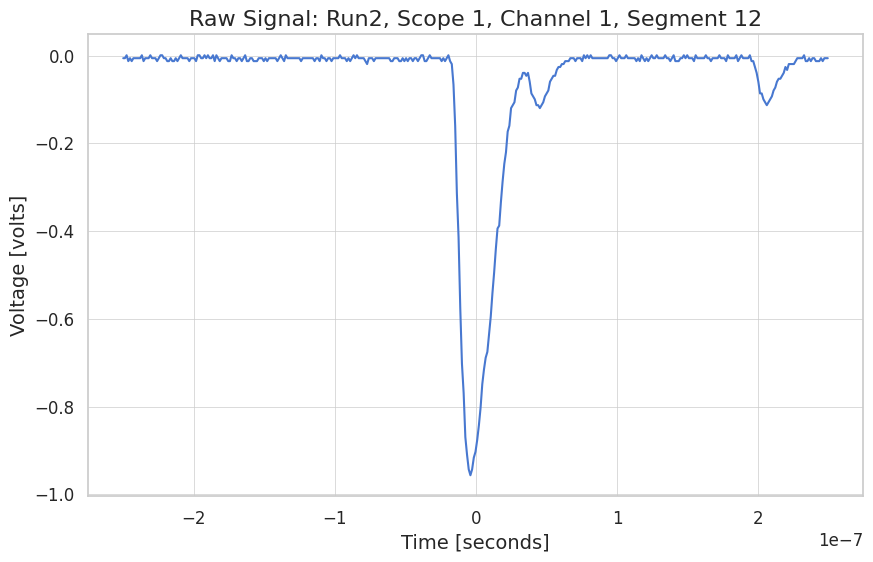

In [50]:
# Pick scope, segment and channel
scope = 1 # [1,2]
seg   = 12
ch    = 1 # [1,8] for Runs [1,16], [1,4] for Runs [17, 30] 

# Raw waveform loading
csvpath = os.path.join(LocalDataPath, f"Run{run}/scope-{scope}-seg{seg}-ch{ch}.csv")
wf = Waveform(csvpath)

# Get the x,y data from class and plot
x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [seconds]")
plt.ylabel("Voltage [volts]")
plt.title(f"Raw Signal: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

### 2. Rescaling

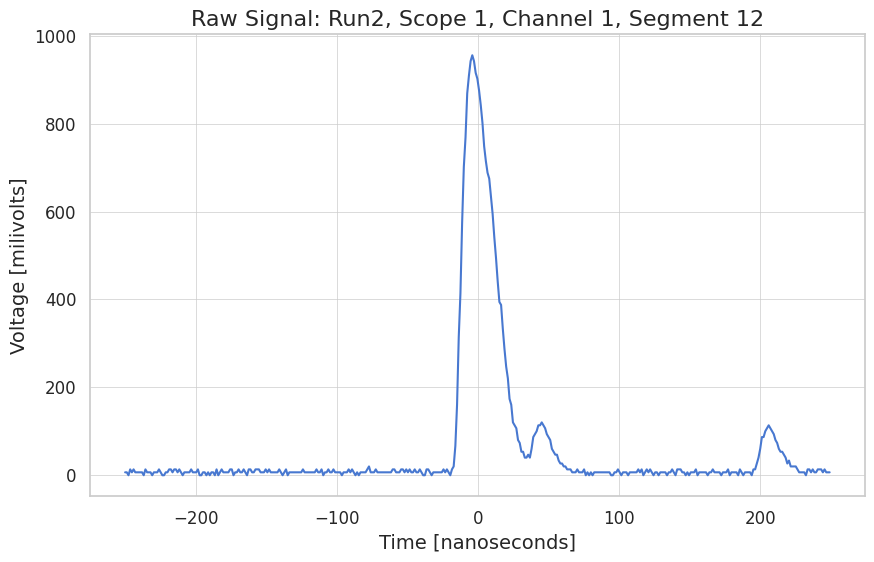

In [51]:
xfactor = 1e9 # convert to nanoseconds
yfactor = -1e3 # convert to millivolts and flip signal to be positive

wf.rescale(xfactor=xfactor,yfactor=yfactor)

x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")
plt.title(f"Raw Signal: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

### 3. Baseline Calculation

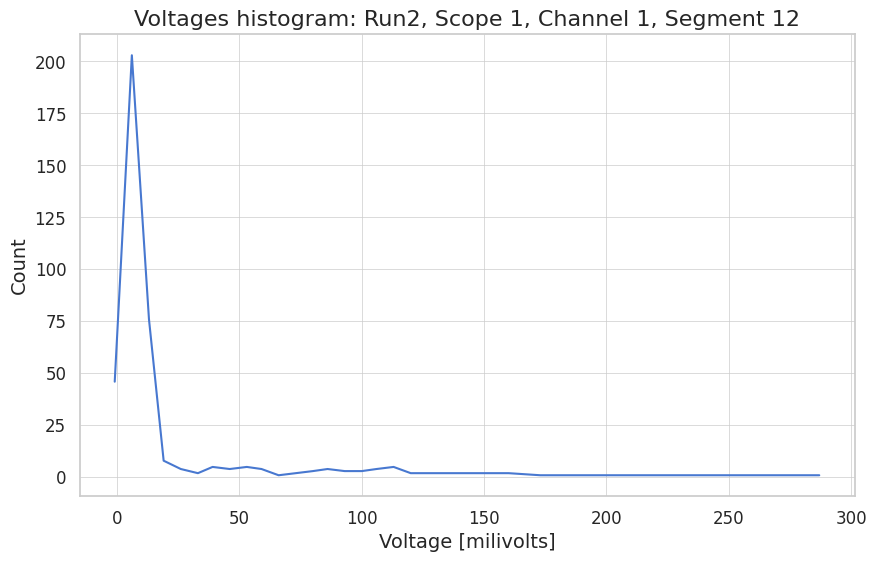

In [52]:
bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages, the baseline should be clearly visible.
plt.plot(bin_mids, hist)
plt.xlabel("Voltage [milivolts]")
plt.ylabel("Count")
plt.title(f"Voltages histogram: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

plt.show();

### 4. Baseline Zeroing

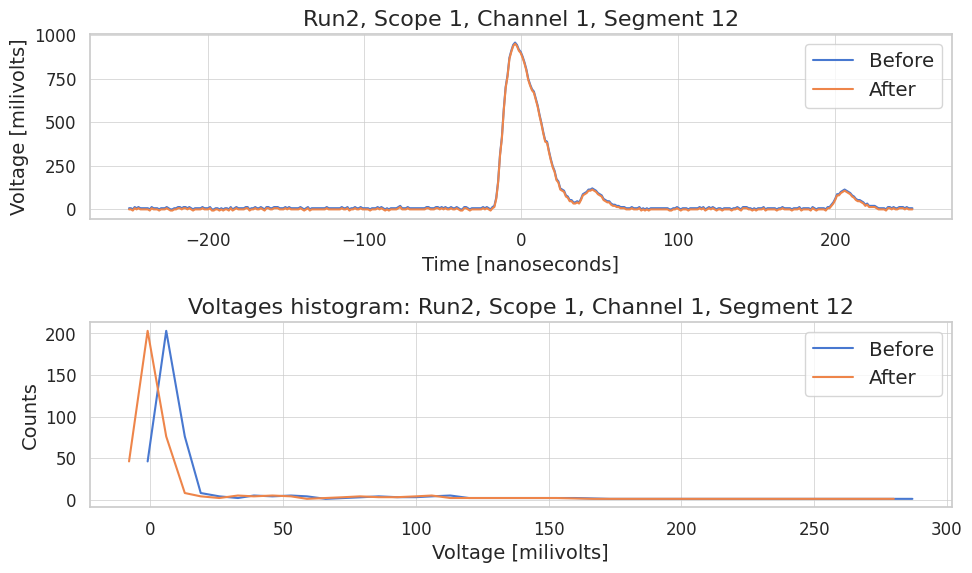

In [53]:
# ! If you run this block twice the difference would disappear, since the baseline would
# ! have already been removed.

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# Plot waveform before zeroing
x, y = wf.get_data(zipped=False)
ax1.plot(x, y, label = "Before")
ax1.set_xlabel("Time [nanoseconds]")
ax1.set_ylabel("Voltage [milivolts]")

bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages before zeroing
ax2.plot(bin_mids, hist, label = "Before")
ax2.set_xlabel("Voltage [milivolts]")
ax2.set_ylabel("Counts")


wf.zero_baseline()

# Plot waveform before zeroing
x, y = wf.get_data(zipped=False)
ax1.plot(x, y, label = "After")
ax1.set_xlabel("Time [nanoseconds]")
ax1.set_ylabel("Voltage [milivolts]")
ax1.set_title(f"Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

bin_mids, hist = wf.calculate_baseline(verbose=True)
baseline       = wf.get_baseline()

# Plot the histogram of voltages before zeroing
ax2.plot(bin_mids, hist, label = "After")
ax2.set_xlabel("Voltage [milivolts]")
ax2.set_ylabel("Counts")
ax2.set_title(f"Voltages histogram: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")

ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show();

### 5. Smoothing

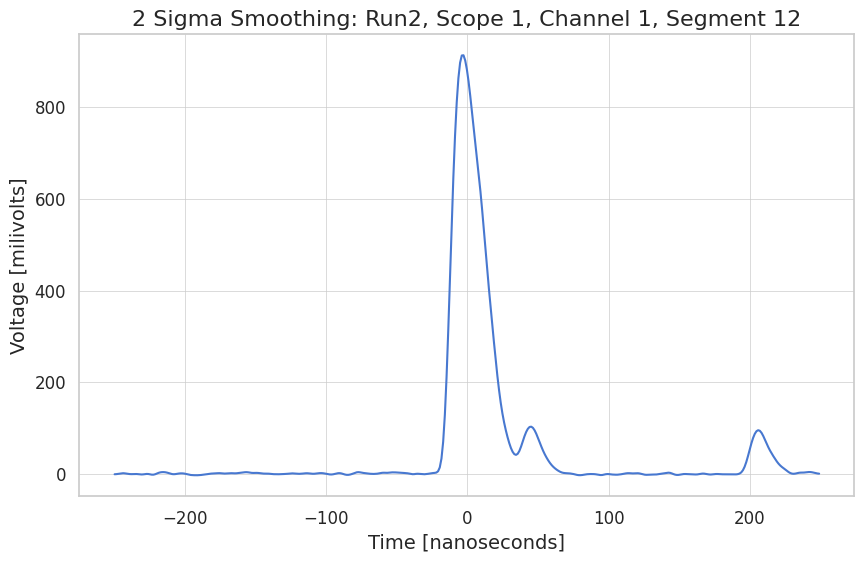

In [54]:
sigma = 2 # Default is = 2
wf.smooth(sigma=sigma)

x, y = wf.get_data(zipped=False)
plt.plot(x, y)
plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")
plt.title(f"{sigma} Sigma Smoothing: Run{run}, Scope {scope}, Channel {ch}, Segment {seg}")
plt.show();

### 6. Detecting the Main Peak

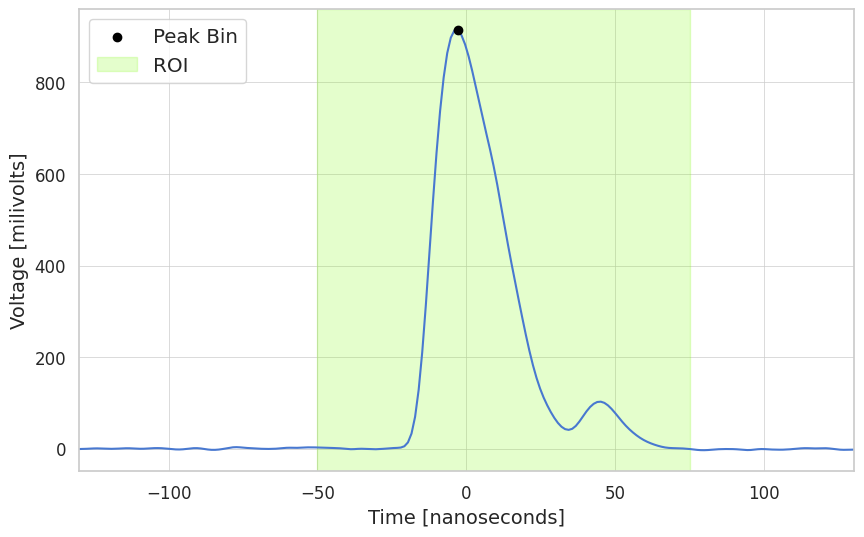

In [55]:
# Convert region of interest to index
x,y = wf.get_data(zipped=False)
a = np.argmin(np.abs(x - ROI_t[0]))
b = np.argmin(np.abs(x - ROI_t[1]))

ROI_idx = [a,b]

# Run peak detection method
wf.detect_main_peak(ROI_idx, 125)

try:
    peak_idx, peak_val            = wf.get_main_peak()
    plt.scatter(x[peak_idx], y[peak_idx], color = 'black', zorder=3, label = "Peak Bin")
except:
    print("No peak detected")

plt.axvspan(T_MIN, T_MAX, color = 'lawngreen', alpha = 0.2, label = 'ROI')

plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")

plt.xlim(x[PLOT_CUT], x[-PLOT_CUT])
plt.legend()
plt.plot(x,y);

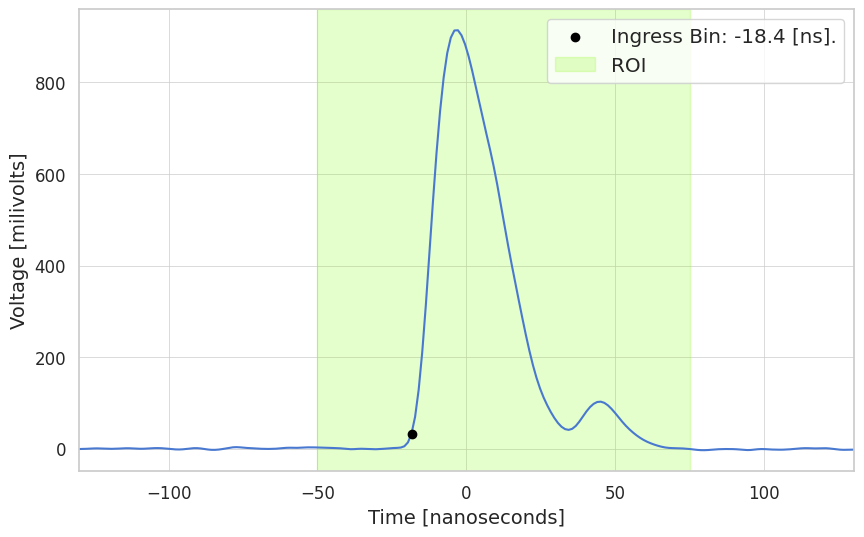

In [56]:
# Convert region of interest to index
x,y = wf.get_data(zipped=False)
a = np.argmin(np.abs(x - ROI_t[0]))
b = np.argmin(np.abs(x - ROI_t[1]))

ROI_idx = [a,b]

wf.identify_ingress(25, ROI_idx);

try:
    ingress_idx, ingress_time_val = wf.get_ingress()
    plt.scatter(x[ingress_idx], y[ingress_idx], color = 'black', 
                zorder=3, label = f"Ingress Bin: {np.round(ingress_time_val,2)} [ns].")
except:
    print("Failed to detect ingress time.")

plt.axvspan(T_MIN, T_MAX, color = 'lawngreen', alpha = 0.2, label = 'ROI')

plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")

plt.xlim(x[PLOT_CUT], x[-PLOT_CUT])
plt.legend()
plt.plot(x,y);

## Using the Waveform Class to Calculate Arrival Time Delay

In [57]:
# Define a function to automatically fully process the csv waveform file
# (Make sure to first run 'define parameters' block at the top of the notebook)
def process_waveform(csvfile):

    wf = Waveform(csvfile)
    wf.read_from_csv()
    wf.rescale(xfactor=1e9,yfactor=-1e3)
    wf.calculate_baseline()
    wf.zero_baseline()
    wf.smooth()
    
    x,y = wf.get_data(zipped=False)
    plt.plot(x,y)
    
    a = np.argmin(np.abs(x - ROI_t[0]))
    b = np.argmin(np.abs(x - ROI_t[1]))
    
    ROI_idx = [a,b]
    
    wf.detect_main_peak(ROI_idx, 125)
    wf.identify_ingress(25, ROI_idx);
    
    try:
        peak_idx, peak_val            = wf.get_main_peak()
    except:
        print("No peaks detected")
    
    try:
        ingress_idx, ingress_time_val = wf.get_ingress()
        plt.scatter(x[ingress_idx], y[ingress_idx], 
                zorder=3, label = f"Ingress Bin: {np.round(ingress_time_val,2)} [ns].")
    except:
        print("No ingress detected")

    return ingress_time_val

Arrival time delay: 4.86 [ns]


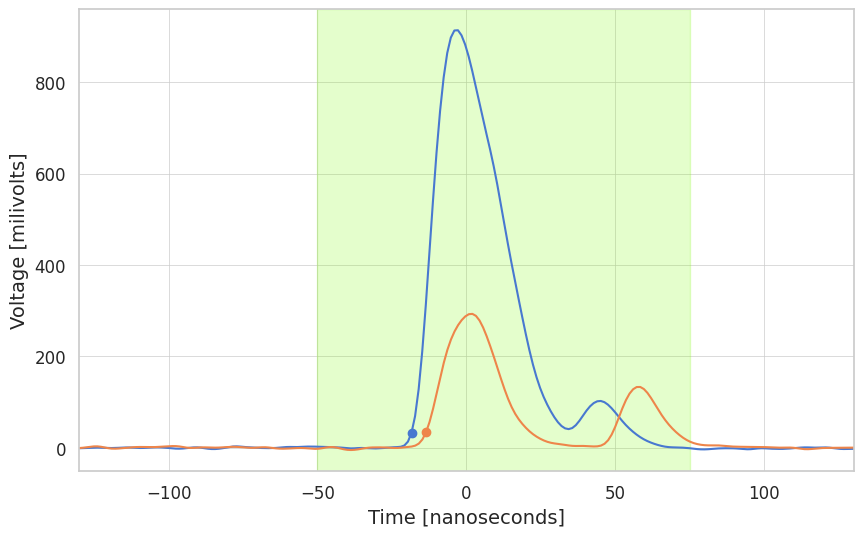

In [58]:
# Scope and segment must be the same for both channels to make sense
# channels have to come in pairs (1,2), (2,3) etc to make sense

# Pick scope, segment and channel
scope = 1 
seg   = 12 
ch    = 1

# Raw waveform loading
csvpath_1 = os.path.join(LocalDataPath, f"Run{run}/scope-{scope}-seg{seg}-ch{ch}.csv")

# Pick scope, segment and channel
scope = 1 
seg   = 443 
ch    = ch + 1

# Raw waveform loading
csvpath_2 = os.path.join(LocalDataPath, f"Run{run}/scope-{scope}-seg{seg}-ch{ch}.csv")

# Process waveforms
ingress_time_val_1 = process_waveform(csvpath_1)
ingress_time_val_2 = process_waveform(csvpath_2)

plt.axvspan(T_MIN, T_MAX, color = 'lawngreen', alpha = 0.2, label = 'ROI')

plt.xlabel("Time [nanoseconds]")
plt.ylabel("Voltage [milivolts]")

plt.xlim(x[PLOT_CUT], x[-PLOT_CUT])

# Get the arrival time delay
atd = np.round(ingress_time_val_2 - ingress_time_val_1, 2)
print(f"Arrival time delay: {atd} [ns]")